In [ ]:
!pip install pydicom
!pip install dicom
!pip install pylidc

In [ ]:
!pip install -U albumentations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


import os
from tqdm.notebook import tqdm

# import dicom
# import pydicom
# from pydicom.data import get_testdata_file
# from pydicom.waveforms import generate_multiplex

from PIL import Image


# from keras.models import Sequential
# from keras.layers.core import Dense, Dropout, Activation, Flatten
# from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D


Source for similar dataset (incomplete)
https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=5800702

In [ ]:
# ! pip install -q kaggle
from google.colab import files
import json
print('Browse and upload kaggle JSON for API')
files.upload()
try:
  ! mkdir ~/.kaggle
except: pass

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels
# fetching the data using kaggle API

# you can download the json file from  your kaggle profile
# will take approx 5-8 mins

Browse and upload kaggle JSON for API


Saving kaggle.json to kaggle.json
100% 9.57G/9.58G [01:36<00:00, 78.0MB/s]
100% 9.58G/9.58G [01:36<00:00, 107MB/s] 


In [ ]:
# source for faster code:  https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial

In [ ]:
!unzip /content/chest-xray-masks-and-labels.zip -d cancer_data
# will take approx 3 mins

Archive:  /content/chest-xray-masks-and-labels.zip
  inflating: cancer_data/Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb  
  inflating: cancer_data/Lung Segmentation/CXR_png/CHNCXR_0001_0.png  
  inflating: cancer_data/Lung Segmentation/CXR_png/CHNCXR_0002_0.png  
  inflating: cancer_data/Lung Segmentation/CXR_png/CHNCXR_0003_0.png  
  inflating: cancer_data/Lung Segmentation/CXR_png/CHNCXR_0004_0.png  
  inflating: cancer_data/Lung Segmentation/CXR_png/CHNCXR_0005_0.png  
  inflating: cancer_data/Lung Segmentation/CXR_png/CHNCXR_0006_0.png  
  inflating: cancer_data/Lung Segmentation/CXR_png/CHNCXR_0007_0.png  
  inflating: cancer_data/Lung Segmentation/CXR_png/CHNCXR_0008_0.png  
  inflating: cancer_data/Lung Segmentation/CXR_png/CHNCXR_0009_0.png  
  inflating: cancer_data/Lung Segmentation/CXR_png/CHNCXR_0010_0.png  
  inflating: cancer_data/Lung Segmentation/CXR_png/CHNCXR_0011_0.png  
  inflating: cancer_data/Lung Segmentation/CXR_png/CHNCXR_0012_0.png  
  inf

In [ ]:
data_dir = '/content/cancer_data/Lung Segmentation/'
images_path = 'CXR_png/'
masks_path = 'masks/'
test_path = 'test/'

# Observing sample images from the dataset

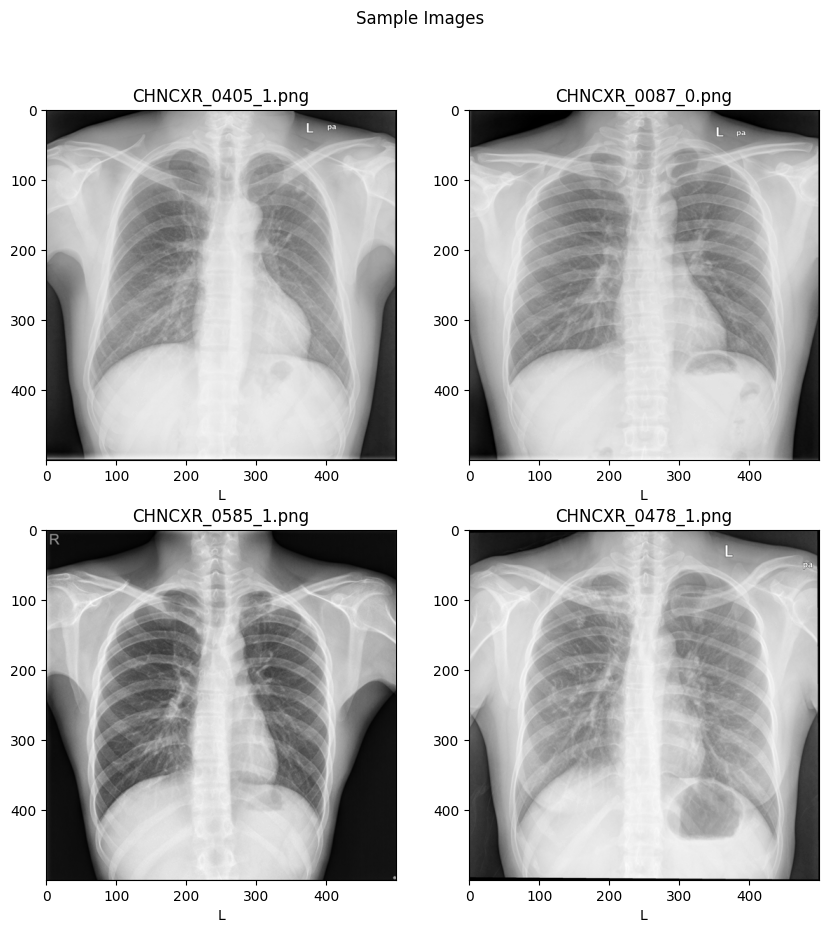

In [ ]:
# for patient in list(os.listdir(data_dir+images_path)):

#     print(patient)

#     path = data_dir + images_path + patient
#     img = Image.open(path)

#     print(img)

#     # plt.imshow(img,cmap= 'Greys_r')
#     break


plt.figure(figsize = (10,10))

for num,patient in enumerate(os.listdir(data_dir+images_path)[:4]):


  plt.subplot(2,2,num+1)
  plt.suptitle('Sample Images')

  path_to_images = data_dir + images_path + patient

  sample = Image.open(path_to_images).convert('L')
  sample = sample.resize((500,500))
  # plt.figure()
  plt.title(patient)
  plt.xlabel(sample.mode)
  plt.imshow(sample, cmap = 'gray')
  # break

#Normalizing the images

In [ ]:
train_images = [] # to store the image arrays

mask_images = [] # to store mask arrays

count_absent = 0 # to count absent masks

In [ ]:
print("Number of images -->", len(os.listdir(data_dir + images_path)))
print("Number of masks  -->", len(os.listdir(data_dir + masks_path)))

704

## Reading images and transforming into arrays

In [ ]:
for patient in tqdm(os.listdir(data_dir + images_path)):

  try:
    # for finding exceptions where mask is not present

    path_to_image = data_dir + images_path + patient
    path_to_mask = data_dir + masks_path + patient.replace('.png', '_mask.png')
    # print(path_to_image)
    # print(path_to_mask)
    # full path to the images

    img = Image.open(path_to_image)
    mask_img = Image.open(path_to_mask)
    # reading the image using PIL

    img = img.convert('L') # conversion into palletized version
    mask_img = mask_img.convert('L') # conversion into palletized version

    img = img.resize((256,256)) # resizing all the images being read
    mask_img = mask_img.resize((256,256)) # resizing all the images being read

    img = np.array(img) # transforming into array
    mask_img = np.array(mask_img) # transforming into array

    train_images.append(img) # storing the image
    mask_images.append(mask_img) # storing the image

  except Exception as err:
    # print(err, '  (mask not found)')
    count_absent +=1
    pass

print(f'{count_absent} masks were not found out of a total {len(os.listdir(data_dir + images_path))}')





  0%|          | 0/800 [00:00<?, ?it/s]

234 masks were not found out of a total 800


In [ ]:
train_images = np.asarray(train_images)
mask_images = np.asarray(mask_images)

In [ ]:
print('Image_array', '-->', train_images[0],'\n')
print('Image_array shape', '-->', train_images.shape,'\n')
print('Image_array size', '-->', len(train_images),'\n')
print('='*40,'\n')
print('Mask_array', '-->', mask_images[0],'\n')
print('Mask_array shape', '-->', mask_images.shape,'\n')
print('Mask_array size', '-->', len(mask_images),'\n')

Image_array --> [[ 29  29  29 ...  28  29  24]
 [ 22  21  22 ...  21  21  18]
 [ 17  16  16 ...  17  16  14]
 ...
 [ 17  17  17 ... 148 147  48]
 [ 16  17  17 ... 158 163  74]
 [ 15  16  15 ...  78  79  19]] 

Image_array shape --> (566, 256, 256) 

Image_array size --> 566 


Mask_array --> [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

Mask_array shape --> (566, 256, 256) 

Mask_array size --> 566 



# Visualizing masks over images

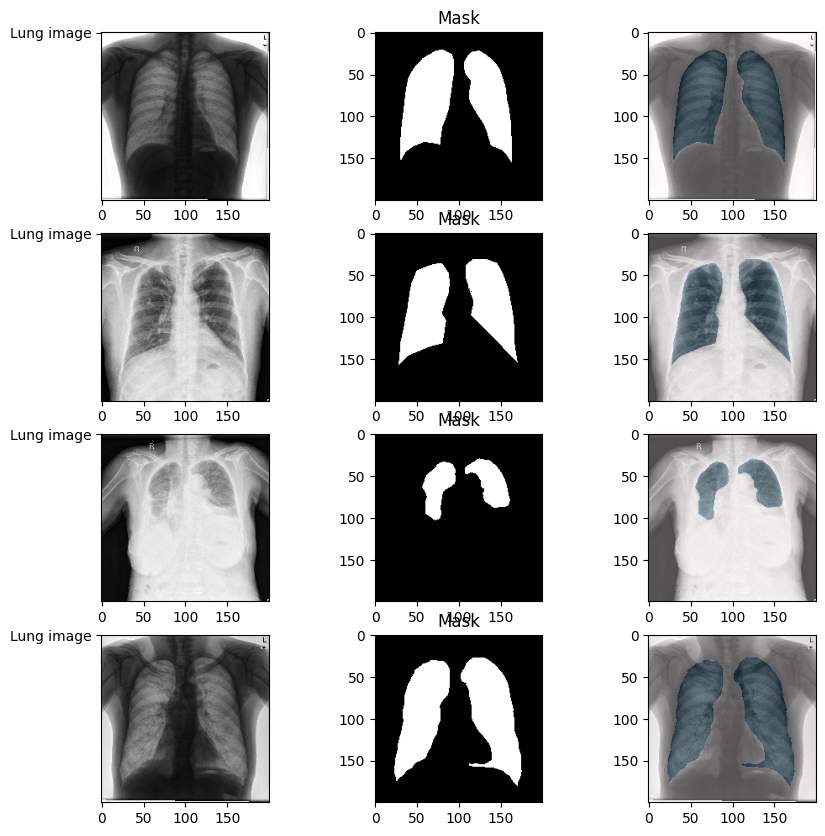

In [ ]:
xray_num = [19,33,100,234] # put 4 random values here (value criteria : < len(training images))

plt.figure(figsize = (10,10))

for num,i in enumerate(xray_num):

  img = train_images[i]
  mask = mask_images[i]

  plt.subplot(4,3,(num*3) +1)
  # plot details
  plt.plot('Lung image')
  plt.imshow(img, cmap='gray')

  plt.subplot(4,3,(num*3) +2)
  # plot details
  plt.title('Mask')
  plt.imshow(mask, cmap= 'gray')

  plt.subplot(4,3,(num*3) +3)
  # plot details
  plt.imshow(img, cmap = "gray")
  plt.imshow(mask , cmap="PuBu", alpha=0.3)

# Augmnentations using Albumentation

In [ ]:
import albumentations as A

In [ ]:
# source : https://albumentations.ai/docs/examples/tensorflow-example/

In [ ]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image, cmap= 'gray')
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask, cmap= 'gray')
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image, cmap= 'gray')
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask, cmap= 'gray')
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [ ]:
aug_images =[]
aug_masks = []

In [ ]:
aug = A.Compose([
            A.Rotate(limit=30),
            A.RandomBrightness(limit=0.1),
            A.JpegCompression(quality_upper=100, quality_lower=85, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.RandomContrast(limit=0.2, p=0.5),
            A.HorizontalFlip(p=0.7),
        ])
# source : https://albumentations.ai/docs/examples/example_kaggle_salt/


for num in range(len(train_images)):

  augmented = aug(image=train_images[num], mask=mask_images[num])
  aug_images.append(augmented['image'])
  aug_masks.append(augmented['mask'])


# visualize(image_padded, mask_padded, original_image=train_images[1], original_mask=mask_images[1])

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:311: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/functional.py:157: UserWarning: HueSaturationValue: hue_shift and sat_shift are not applicable to grayscale image. Set them to 0 or use RGB image
  warn(


Combining original and augmented dataset

In [ ]:
train_images = np.concatenate((train_images, np.asarray(aug_images)),axis = 0)
mask_images = np.concatenate((mask_images, np.asarray(aug_masks)),axis = 0)

# train test split

In [ ]:
# 10% will be kept for training
# test_images = train_images[:len(train_images)*0.1]
# train_images = train_images[len(train_images)*0.1:]
# test_masks = mask_images[:len(mask_images)*0.1]
# train_masks = mask_images[len(mask_images)*0.1:]


# not necessary when using validation_split parameter

#Model



In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.optimizers import Adam
from keras import backend as keras
from keras.metrics import MeanIoU

In [ ]:
# source : https://www.youtube.com/watch?v=Pk7o3r220ik
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

In [ ]:
# Define your U-Net model
def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)


    """
    Simple model approach to understand
    how these layers affect the spatial info

    remember this for easier sampling approach:
    https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/
    """

    # Encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    up1 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv2), conv1], axis=3)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up1)

    return Model(inputs=inputs, outputs=outputs)

# Set the number of epochs consistently
EPOCHS = 100

# Compile your model with appropriate metrics
model = unet(input_size=(256, 256, 1))
# Adjust learning rate
model.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy",
              metrics=[dice_coef, 'accuracy', MeanIoU(num_classes=2)])


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
train_images = np.asarray([i/255 for i in train_images])
mask_images= np.asarray([i/255 for i in mask_images])

In [ ]:


# Early stopping based on validation dice coefficient
earlystopping = EarlyStopping(monitor='val_dice_coef', patience=10, mode='max')

checkpointer = ModelCheckpoint('lung_model.h5', verbose=1, save_best_only=True)

# Train your model
history = model.fit(x=train_images, y=mask_images, validation_split=0.1,
                    epochs=EPOCHS, batch_size=32, callbacks=[earlystopping])



Epoch 1/100
32/32 [==============================] - 23s 214ms/step - loss: 0.5722 - dice_coef: 0.2799 - accuracy: 0.7339 - mean_io_u: 0.3780 - val_loss: 0.5477 - val_dice_coef: 0.2716 - val_accuracy: 0.7375 - val_mean_io_u: 0.3778
Epoch 2/100
32/32 [==============================] - 3s 91ms/step - loss: 0.5169 - dice_coef: 0.2847 - accuracy: 0.7380 - mean_io_u: 0.3780 - val_loss: 0.4890 - val_dice_coef: 0.3084 - val_accuracy: 0.7375 - val_mean_io_u: 0.3778
Epoch 3/100
32/32 [==============================] - 3s 92ms/step - loss: 0.4649 - dice_coef: 0.3281 - accuracy: 0.7380 - mean_io_u: 0.3780 - val_loss: 0.4422 - val_dice_coef: 0.3537 - val_accuracy: 0.7375 - val_mean_io_u: 0.3778
Epoch 4/100
32/32 [==============================] - 3s 92ms/step - loss: 0.3951 - dice_coef: 0.4227 - accuracy: 0.7743 - mean_io_u: 0.3780 - val_loss: 0.3924 - val_dice_coef: 0.4600 - val_accuracy: 0.8183 - val_mean_io_u: 0.3778
Epoch 5/100
32/32 [==============================] - 3s 95ms/step - loss: 0.35

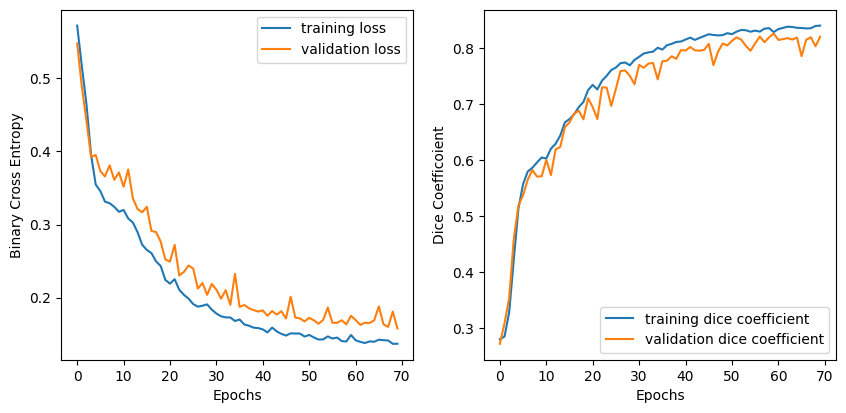

In [ ]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Binary Cross Entropy")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Dice Coefficoient")

get_metrics(history = history)

# Evaluation

In [ ]:
test_images =[]
# test_masks =[]

In [ ]:
# path_to_image = data_dir + test_path + patient
# path_to_mask = data_dir + masks_path + patient.replace('.png', '_mask.png')
# print(path_to_image)
# print(path_to_mask)
# full path to the images
path_to_your_image = "/content/test2.jpg"
img = Image.open(path_to_your_image)
# reading the image using PIL

img = img.convert('L') # conversion into palletized version

img = img.resize((256,256)) # resizing all the images being read

img = np.array(img)/255 # transforming into array

test_images.append(img) # storing the image


In [ ]:
test_images = np.asarray(test_images)
preds = model.predict(test_images)
# makin predicts

1/1 [==============================] - 0s 32ms/step


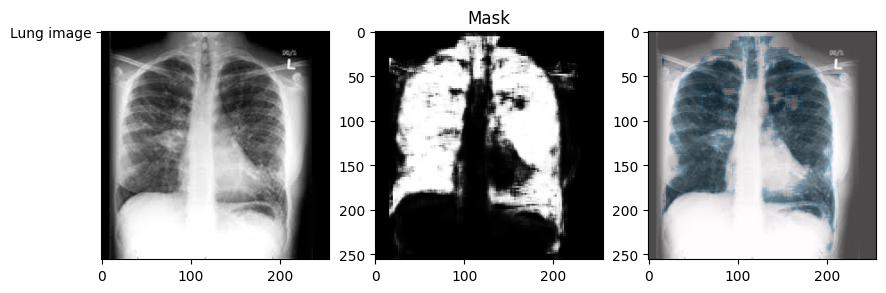

In [ ]:
num = 0
img = test_images[0]
mask = preds[0]
# plotting prediction

plt.figure(figsize=(10,10))
plt.subplot(1,3,(num*3) +1)
# plot details
plt.plot('Lung image')
plt.imshow(img, cmap='gray')

plt.subplot(1,3,(num*3) +2)
# plot details
plt.title('Mask')
plt.imshow(mask, cmap= 'gray')

plt.subplot(1,3,(num*3) +3)
# plot details
plt.imshow(img, cmap = "gray")
plt.imshow(mask , cmap="PuBu", alpha=0.3)

Complex model


In [ ]:
# IMG_HEIGHT= 128
# IMG_WIDTH = 128

# #Build the model
# inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH,1))
# scaler = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
# # scaling because floating values is  better
# # source : https://www.youtube.com/watch?v=RaswBvMnFxk&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE&index=6




# #Contraction path
# # how 2d CONV if input is 3d
# # source : https://stackoverflow.com/questions/42883547/intuitive-understanding-of-1d-2d-and-3d-convolutions-in-convolutional-neural-n

# # architecture needs to be tuned according to the images (biomedical)
# # source :
# c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(scaler)
# c1 = tf.keras.layers.Dropout(0.1)(c1)
# c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
# p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
# c2 = tf.keras.layers.Dropout(0.1)(c2)
# c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
# p3 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# # c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
# # c3 = tf.keras.layers.Dropout(0.2)(c3)
# # c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
# # p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
# c4 = tf.keras.layers.Dropout(0.2)(c4)
# c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
# p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

# c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
# c5 = tf.keras.layers.Dropout(0.3)(c5)
# c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# #Expansive path
# u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
# u6 = tf.keras.layers.concatenate([u6, c4])
# c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
# c6 = tf.keras.layers.Dropout(0.2)(c6)
# c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# # u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
# # u7 = tf.keras.layers.concatenate([u7, c3])
# # c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
# # c7 = tf.keras.layers.Dropout(0.2)(c7)
# # c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
# u8 = tf.keras.layers.concatenate([u8, c2])
# c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
# c8 = tf.keras.layers.Dropout(0.1)(c8)
# c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
# u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
# c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
# c9 = tf.keras.layers.Dropout(0.1)(c9)
# c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

# model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

# ################################
# #Modelcheckpoint
# checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

# callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
#         tf.keras.callbacks.TensorBoard(log_dir='logs')]

# results = model.fit(train_images, mask_images, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)
